In [59]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns
import numpy 
import pandas


from tqdm.auto import tqdm
from helper_functions import accuracy_fn
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
train_dataset = torchvision.datasets.MNIST(
    "/data",
    train=True,
    transform=ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.MNIST(
    "/data",
    train=False,
    transform=ToTensor(),
    download=True
)

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=True)
classes = train_dataset.classes


In [28]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [116]:
class CNNDigits(nn.Module):
    def __init__(self):
        super(CNNDigits, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 10)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return self.classifier(x)

In [117]:
model = CNNDigits().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [120]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch n.{epoch}")
    train_loss = 0
    train_acc = 0
    
    # Training
    for (X, y) in train_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss}, Train acc: {train_acc}")
    
    # Testing 
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for (X, y) in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss
            test_acc += accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"Test loss: {test_loss}, Test acc: {test_acc}")
        



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch n.0
Train loss: 0.22839480638504028, Train acc: 92.82833333333333
Test loss: 0.07934419810771942, Test acc: 97.38
Epoch n.1
Train loss: 0.08423283696174622, Train acc: 97.42
Test loss: 0.06466662883758545, Test acc: 97.86
Epoch n.2
Train loss: 0.06721628457307816, Train acc: 97.94833333333334
Test loss: 0.04903802275657654, Test acc: 98.42


In [121]:
y_preds = []
y_trues = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataset, desc="Making predictions"):
        y_logits = model(X.unsqueeze(0))

        y_pred = torch.softmax(y_logits, dim=1).squeeze().argmax(dim=0)     
        y_preds.append(y_pred)
        y_trues.append(y)
        

Making predictions:   0%|          | 0/10000 [00:00<?, ?it/s]

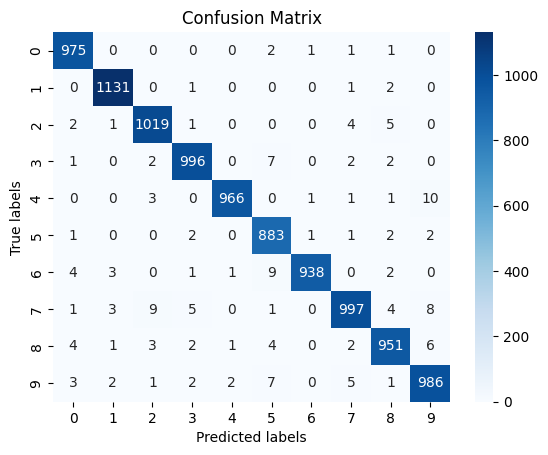

In [122]:
cm = confusion_matrix(y_true=y_trues, y_pred=y_preds)
# Create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Set axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()
